In [1]:
from functions_for_all_nutrients import *
from iron_hemoglobin_functions import *

In [2]:
username = !whoami
username

['alibow']

In [3]:
index_cols=['location_id','sex_id','age_group_id']

age_group_ids = list(range(7,16))
sex_ids = [2]
coverage_levels = [0.2,0.5,0.8]
years = [2021,2022,2023,2024,2025]

In [4]:
coverage_data_dir = f'/ihme/homes/{username[0]}/notebooks/vivarium_research_lsff/data_prep/outputs/lsff_input_coverage_data.csv'

In [5]:
location_ids = (list(
                pd.read_csv(coverage_data_dir)
                .location_id
                .unique()))
location_ids

[179, 163, 214, 161, 165, 190, 189, 196]

In [6]:
nutrient = 'iron'
vehicle = 'wheat flour'
effective_fractions = [1] * len(age_group_ids)

In [7]:
baseline_coverage, counterfactual_coverage = generate_overall_coverage_rates(
                                                     coverage_data_dir,
                                                     nutrient, 
                                                     vehicle,
                                                     coverage_levels,
                                                     years,
                                                     location_ids,
                                                    ['women of reproductive age','total population',np.nan])

# HEMOGLOBIN

In [8]:
from scipy.stats import norm

# mean and 0.975-quantile of normal distribution for mean difference (MD)
mean = 3
q_975 = 6.1

# 0.975-quantile of standard normal distribution (=1.96, approximately)
q_975_stdnorm = norm().ppf(0.975)

std = (q_975 - mean) / q_975_stdnorm # std dev of normal distribution

# Frozen normal distribution for MD, representing uncertainty in our effect size
hb_md_distribution = norm(mean, std)

In [9]:
mean_difference_hemoglobin_fort = generate_normal_rr_deficiency_nofort_draws(mean, std, location_ids)
mean_difference_hemoglobin_fort.head()

draws,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,draw_105,draw_106,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
location_id,,,,,,,,,,,,,,,,,,,,,
179,5.67384,2.263045,2.010783,1.632669,3.592127,3.619293,0.71747,3.769218,2.099288,5.25659,...,2.68253,2.315703,4.976409,5.670455,1.949907,3.061148,3.881265,2.227427,2.005891,1.92852
163,5.67384,2.263045,2.010783,1.632669,3.592127,3.619293,0.71747,3.769218,2.099288,5.25659,...,2.68253,2.315703,4.976409,5.670455,1.949907,3.061148,3.881265,2.227427,2.005891,1.92852
214,5.67384,2.263045,2.010783,1.632669,3.592127,3.619293,0.71747,3.769218,2.099288,5.25659,...,2.68253,2.315703,4.976409,5.670455,1.949907,3.061148,3.881265,2.227427,2.005891,1.92852
161,5.67384,2.263045,2.010783,1.632669,3.592127,3.619293,0.71747,3.769218,2.099288,5.25659,...,2.68253,2.315703,4.976409,5.670455,1.949907,3.061148,3.881265,2.227427,2.005891,1.92852
165,5.67384,2.263045,2.010783,1.632669,3.592127,3.619293,0.71747,3.769218,2.099288,5.25659,...,2.68253,2.315703,4.976409,5.670455,1.949907,3.061148,3.881265,2.227427,2.005891,1.92852


In [10]:
# NOTE:
# This approach currently does not consider that new coverage
# applies to those who are slightly more anemic
# than the overall population due to their lack
# of access to fortification

effective_baseline_coverage = get_effective_iron_hemoglobin_coverage(baseline_coverage, 
                                                                     sex_ids, 
                                                                     age_group_ids, 
                                                                     effective_fractions, 
                                                                     years)
effective_counterfactual_coverage = get_effective_iron_hemoglobin_coverage(counterfactual_coverage, 
                                                                     sex_ids, 
                                                                     age_group_ids, 
                                                                     effective_fractions, 
                                                                     years)

delta_effective_coverage = effective_counterfactual_coverage - effective_baseline_coverage
delta_effective_coverage

draw_0    draw_1  \
location_id sex_id age_group_id year coverage_level                       
161         2      7            2021 0.2             0.000000  0.000000   
                                     0.5             0.000000  0.000000   
                                     0.8             0.000000  0.000000   
                                2022 0.2             0.016512  0.022542   
                                     0.5             0.041794  0.057059   
...                                                       ...       ...   
214         2      15           2024 0.5             0.131819  0.129636   
                                     0.8             0.311482  0.310637   
                                2025 0.2            -0.047843 -0.051366   
                                     0.5             0.131819  0.129636   
                                     0.8             0.311482  0.310637   

                                                       draw_2    draw_3  \
location_id sex_id age_group_id year coverage_level                       
161         2      7            2021 0.2             0.000000  0.000000   
                                     0.5             0.000000  0.000000   
                                     0.8             0.000000  0.000000   
                                2022 0.2             0.013770  0.015775   
                                     0.5             0.034854  0.039930   
...                                                       ...       ...   
214         2      15           2024 0.5             0.134415  0.125561   
                                     0.8             0.312486  0.309060   
                                2025 0.2            -0.043657 -0.057938   
                                     0.5             0.134415  0.125561   
                                     0.8             0.312486  0.309060   

                                                       draw_4    draw_5  \
location_id sex_id age_group_id year coverage_level                       
161         2      7            2021 0.2             0.000000  0.000000   
                                     0.5             0.000000  0.000000   
                                     0.8             0.000000  0.000000   
                                2022 0.2             0.020130  0.015030   
                                     0.5             0.050954  0.038045   
...                                                       ...       ...   
214         2      15           2024 0.5             0.126736  0.123877   
                                     0.8             0.309515  0.308409   
                                2025 0.2            -0.056044 -0.060655   
                                     0.5             0.126736  0.123877   
                                     0.8             0.309515  0.308409   

                                                       draw_6    draw_7  \
location_id sex_id age_group_id year coverage_level                       
161         2      7            2021 0.2             0.000000  0.000000   
                                     0.5             0.000000  0.000000   
                                     0.8             0.000000  0.000000   
                                2022 0.2             0.020711  0.013782   
                                     0.5             0.052423  0.034885   
...                                                       ...       ...   
214         2      15           2024 0.5             0.140676  0.133774   
                                     0.8             0.314909  0.312239   
                                2025 0.2            -0.033557 -0.044690   
                                     0.5             0.140676  0.133774   
                                     0.8             0.314909  0.312239   

                                                       draw_8    draw_9  ...  \
location_id sex_id age_group_id year coverage_level                    

In [11]:
mean_hgb = generate_hemoglobin_values(delta_effective_coverage, 
                                      mean_difference_hemoglobin_fort,
                                      location_ids, age_group_ids, sex_ids)
mean_hgb.to_csv('anemia_files_wra/mean_hgb_wra.csv')
mean_hgb = mean_hgb.reset_index().rename(columns={'year_id':'year'}).set_index(['location_id','sex_id','age_group_id','coverage_level','year'])
mean_hgb

/ihme/homes/alibow/notebooks/vivarium_research_lsff/multiplication_models/iron_hemoglobin_functions.py:112: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  ignore_index=True)


draw_0      draw_1  \
location_id sex_id age_group_id coverage_level year                             
161         2      7            baseline       NaN     131.576669  130.006851   
                   8            baseline       NaN     118.922773  126.221582   
                   9            baseline       NaN     119.445416  119.744885   
                   10           baseline       NaN     125.283728  125.009121   
                   11           baseline       NaN     125.122521  121.147369   
...                                                           ...         ...   
214         2      15           0.5            2024.0  125.006594  127.972466   
                                0.8            2024.0  126.025972  128.382081   
                                0.2            2025.0  123.987217  127.562852   
                                0.5            2025.0  125.006594  127.972466   
                                0.8            2025.0  126.025972  128.382081   

                                                          draw_10    draw_100  \
location_id sex_id age_group_id coverage_level year                             
161         2      7            baseline       NaN     126.753823  128.018065   
                   8            baseline       NaN     123.354380  126.262134   
                   9            baseline       NaN     123.663548  124.283216   
                   10           baseline       NaN     119.397039  122.817539   
                   11           baseline       NaN     124.487696  128.703954   
...                                                           ...         ...   
214         2      15           0.5            2024.0  123.128989  119.149210   
                                0.8            2024.0  123.497518  119.444652   
                                0.2            2025.0  122.760460  118.853769   
                                0.5            2025.0  123.128989  119.149210   
                                0.8            2025.0  123.497518  119.444652   

                                                         draw_101    draw_102  \
location_id sex_id age_group_id coverage_level year                             
161         2      7            baseline       NaN     133.273591  131.115555   
                   8            baseline       NaN     124.932018  122.562494   
                   9            baseline       NaN     118.579743  124.817976   
                   10           baseline       NaN     123.870315  121.480207   
                   11           baseline       NaN     127.822311  125.583439   
...                                                           ...         ...   
214         2      15           0.5            2024.0  126.779617  122.593702   
                                0.8            2024.0  127.413640  123.239637   
                                0.2            2025.0  126.145594  121.947767   
                                0.5            2025.0  126.779617  122.593702   
                                0.8            2025.0  127.413640  123.239637   

                                                         draw_103    draw_104  \
location_id sex_id age_group_id coverage_level year                             
161         2      7            baseline       NaN     130.538169  127.788556   
                   8            baseline       NaN     124.733401  123.766130   
                   9            baseline       NaN     123.868556  121.465009   
                   10           baseline       NaN     122.020435  124.570332   
                   11           baseline       NaN     122.830292  124.109611   
...                                                           ...         ...   
214         2      15           0.5            2024.0  121.412651  124.084128   
                                0.8            2024.0  121.538989  124.755907   
                                0.2            2025.0  121.286314  123.412349   
      

In [12]:
hgb_sd = get_draws('modelable_entity_id',
                10488,
                source='epi',
                location_id=location_ids,
                age_group_id=age_group_ids,
                sex_id=sex_ids,
                year_id=2019,
                gbd_round_id=6,
                decomp_step='step4',
                status='best')
hgb_sd = (hgb_sd.set_index(['location_id','sex_id','age_group_id'])
 .filter([c for c in hgb_sd if 'draw' in c])
 .reset_index())
hgb_sd.to_csv('anemia_files_wra/sd_hgb_wra.csv')
hgb_sd.head()

,location_id,sex_id,age_group_id,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,161,2,7,13.275545,10.520743,12.478364,11.074315,10.319840,9.552074,11.482975,...,8.870499,11.040565,12.914307,11.682636,11.117577,10.219581,8.650118,11.489875,12.298117,9.942485
1,161,2,8,13.539543,11.400473,10.763228,14.080062,11.942807,11.324351,11.840090,...,11.357083,12.538706,13.177448,12.547561,11.475504,14.670415,15.362374,12.780025,12.573772,12.782688
2,161,2,9,13.528640,13.927886,14.721699,15.840077,11.072700,15.942453,12.677813,...,12.927958,16.020252,13.794109,11.640264,10.280626,13.637941,13.283374,13.921116,12.567939,13.100151
3,161,2,10,13.207735,13.479330,11.098589,12.029322,11.833765,13.670128,13.568723,...,11.926769,13.822309,12.325545,12.042773,13.858020,13.640866,13.487260,13.722549,13.112078,11.246742
4,161,2,11,14.281189,15.560005,13.597733,12.801608,13.592397,11.282292,17.420670,...,15.458890,12.843036,13.522561,13.715516,14.262597,14.525756,12.139305,14.033802,13.578819,15.315098


In [13]:
# get age-specific fertility rate
get_covariate_estimates(13, 
                               location_id=location_ids,
                               age_group_id=age_group_ids,
                               sex_id=sex_ids,
                               year_id=2019,
                               gbd_round_id=6,
                               decomp_step='step4').to_csv('anemia_files_wra/asfr.csv')


# get still birth to live birth ratio (not age-specific)
still = get_covariate_estimates(2267, 
                                location_id=location_ids,
                                year_id=2019,
                                gbd_round_id=6,
                                decomp_step='step4').to_csv('anemia_files_wra/still.csv')

In [11]:
# NOW RUN HEMOGLOBIN_TO_ANEMIA.R FILE BEFORE RUNNING NEXT CELL
assert "Did you run the R file?" == "Double check :)", "Make sure you run the R file!"

AssertionError: Make sure you run the R file!

In [14]:
anemia = load_anemia_prev_and_calculate_ylds('anemia_files_wra/anemia_prev_wra.csv')
baseline_anemia = (duplicate_over_simulation_years(anemia.loc[anemia.coverage_level=='baseline'], years)
                   .drop(columns='coverage_level')
                   .set_index(['location_id','age_group_id','sex_id','year','draw']))
counterfactual_anemia = (anemia.loc[anemia.coverage_level != 'baseline']
                         .set_index(['location_id','age_group_id','sex_id','year','draw','coverage_level']))
averted_anemia = baseline_anemia - counterfactual_anemia
averted_anemia

mild  \
location_id age_group_id sex_id year draw     coverage_level             
161         7            2      2021 draw_0   0.2             0.000000   
                                              0.5             0.000000   
                                              0.8             0.000000   
                                     draw_1   0.2             0.000000   
                                              0.5             0.000000   
...                                                                ...   
214         15           2      2025 draw_998 0.5             0.003326   
                                              0.8             0.008052   
                                     draw_999 0.2            -0.000225   
                                              0.5             0.002017   
                                              0.8             0.004285   

                                                              moderate  \
location_id age_group_id sex_id year draw     coverage_level             
161         7            2      2021 draw_0   0.2             0.000000   
                                              0.5             0.000000   
                                              0.8             0.000000   
                                     draw_1   0.2             0.000000   
                                              0.5             0.000000   
...                                                                ...   
214         15           2      2025 draw_998 0.5             0.003113   
                                              0.8             0.007420   
                                     draw_999 0.2            -0.000488   
                                              0.5             0.004325   
                                              0.8             0.009069   

                                                                severe  \
location_id age_group_id sex_id year draw     coverage_level             
161         7            2      2021 draw_0   0.2             0.000000   
                                              0.5             0.000000   
                                              0.8             0.000000   
                                     draw_1   0.2             0.000000   
                                              0.5             0.000000   
...                                                                ...   
214         15           2      2025 draw_998 0.5             0.000092   
                                              0.8             0.000220   
                                     draw_999 0.2            -0.000042   
                                              0.5             0.000368   
                                              0.8             0.000764   

                                                                anemic  \
location_id age_group_id sex_id year draw     coverage_level             
161         7            2      2021 draw_0   0.2             0.000000   
                                              0.5             0.000000   
                                              0.8             0.000000   
                                     draw_1   0.2             0.000000   
                                              0.5             0.000000   
...                                                                ...   
214         15           2      2025 draw_998 0.5             0.006531   
                                              0.8             0.015691   
                                     draw_999 0.2            -0.000755   
                                              0.5             0.006710   
                                              0.8             0.014118   

                                                                 mild_ylds  \
location_id age_group_id sex_id year draw     coverage_level                 
161         7            2      2021 draw_0   0.2         

In [15]:
counts, rates = population_weight_values(averted_anemia.reset_index(), age_group_ids, sex_ids, location_ids)

In [16]:
counts = summarize_data(counts)
rates = summarize_data(rates)

In [17]:
anemia_counts_averted = (counts.loc[counts.severity=='anemic']
     .loc[counts.measure=='ylds']
     .set_index(['location_id','coverage_level','year'])
     .drop(columns=['severity','measure']))
anemia_counts_averted.head()

draw                                   draw_0       draw_1      draw_10  \
location_id coverage_level year                                           
161         0.2            2021      0.000000     0.000000     0.000000   
            0.5            2021      0.000000     0.000000     0.000000   
            0.8            2021      0.000000     0.000000     0.000000   
            0.2            2022   4565.760866  2384.775388  1893.504963   
            0.5            2022  11497.631618  6019.030333  4782.302445   

draw                                draw_100     draw_101     draw_102  \
location_id coverage_level year                                          
161         0.2            2021     0.000000     0.000000     0.000000   
            0.5            2021     0.000000     0.000000     0.000000   
            0.8            2021     0.000000     0.000000     0.000000   
            0.2            2022  1534.994059  3684.994616  3027.558939   
            0.5            2022  3877.985730  9286.949700  7632.251066   

draw                                draw_103      draw_104     draw_105  \
location_id coverage_level year                                           
161         0.2            2021     0.000000      0.000000     0.000000   
            0.5            2021     0.000000      0.000000     0.000000   
            0.8            2021     0.000000      0.000000     0.000000   
            0.2            2022   785.715974   4342.901913  1826.329766   
            0.5            2022  1986.973557  10939.317967  4610.849814   

draw                                 draw_106  ...     draw_990     draw_991  \
location_id coverage_level year                ...                             
161         0.2            2021      0.000000  ...     0.000000     0.000000   
            0.5            2021      0.000000  ...     0.000000     0.000000   
            0.8            2021      0.000000  ...     0.000000     0.000000   
            0.2            2022   4565.890912  ...  2389.430151  1866.787272   
            0.5            2022  11496.617992  ...  6031.227435  4714.481639   

draw                                 draw_992      draw_993     draw_994  \
location_id coverage_level year                                            
161         0.2            2021      0.000000      0.000000     0.000000   
            0.5            2021      0.000000      0.000000     0.000000   
            0.8            2021      0.000000      0.000000     0.000000   
            0.2            2022   4931.906435   4648.081745  1964.925899   
            0.5            2022  12412.335458  11678.617000  4963.228120   

draw                                draw_995     draw_996     draw_997  \
location_id coverage_level year                                          
161         0.2            2021     0.000000     0.000000     0.000000   
            0.5            2021     0.000000     0.000000     0.000000   
            0.8            2021     0.000000     0.000000     0.000000   
            0.2            2022  2455.799357  3128.209787  2004.312665   
            0.5            2022  6194.747313  7886.565826  5060.576699   

draw                                draw_998     draw_999  
location_id coverage_level year                            
161         0.2            2021     0.000000     0.000000  
            0.5            2021     0.000000     0.000000  
            0.8            2021     0.000000     0.000000  
            0.2            2022  2110.333284  1117.825516  
            0.5            2022  5330.044487  2825.009010  

[5 rows x 1000 columns]

In [18]:
anemia_rates_averted = (rates.loc[rates.severity=='anemic']
     .loc[rates.measure=='ylds']
     .set_index(['location_id','coverage_level','year'])
     .drop(columns=['severity','measure']))
anemia_rates_averted.head()

draw                                draw_0     draw_1   draw_10  draw_100  \
location_id coverage_level year                                             
161         0.2            2021   0.000000   0.000000  0.000000  0.000000   
            0.5            2021   0.000000   0.000000  0.000000  0.000000   
            0.8            2021   0.000000   0.000000  0.000000  0.000000   
            0.2            2022   8.120190   4.241315  3.367592  2.729982   
            0.5            2022  20.448499  10.704825  8.505309  6.896985   

draw                              draw_101   draw_102  draw_103   draw_104  \
location_id coverage_level year                                              
161         0.2            2021   0.000000   0.000000  0.000000   0.000000   
            0.5            2021   0.000000   0.000000  0.000000   0.000000   
            0.8            2021   0.000000   0.000000  0.000000   0.000000   
            0.2            2022   6.553750   5.384503  1.397393   7.723836   
            0.5            2022  16.516809  13.573933  3.533826  19.455540   

draw                             draw_105   draw_106  ...   draw_990  \
location_id coverage_level year                       ...              
161         0.2            2021  0.000000   0.000000  ...   0.000000   
            0.5            2021  0.000000   0.000000  ...   0.000000   
            0.8            2021  0.000000   0.000000  ...   0.000000   
            0.2            2022  3.248121   8.120422  ...   4.249593   
            0.5            2022  8.200381  20.446696  ...  10.726518   

draw                             draw_991   draw_992   draw_993  draw_994  \
location_id coverage_level year                                             
161         0.2            2021  0.000000   0.000000   0.000000  0.000000   
            0.5            2021  0.000000   0.000000   0.000000  0.000000   
            0.8            2021  0.000000   0.000000   0.000000  0.000000   
            0.2            2022  3.320075   8.771379   8.266598  3.494614   
            0.5            2022  8.384690  22.075297  20.770381  8.827084   

draw                              draw_995   draw_996  draw_997  draw_998  \
location_id coverage_level year                                             
161         0.2            2021   0.000000   0.000000  0.000000  0.000000   
            0.5            2021   0.000000   0.000000  0.000000  0.000000   
            0.8            2021   0.000000   0.000000  0.000000  0.000000   
            0.2            2022   4.367631   5.563511  3.564663  3.753221   
            0.5            2022  11.017337  14.026231  9.000219  9.479466   

draw                             draw_999  
location_id coverage_level year            
161         0.2            2021  0.000000  
            0.5            2021  0.000000  
            0.8            2021  0.000000  
            0.2            2022  1.988049  
            0.5            2022  5.024269  

[5 rows x 1000 columns]

In [19]:
# total iron responsive anemia burden
iron_responsive_anemia_sequelae = [1004, 1005, 1006, 1008, 1009, 1010, 1012, 1013, 
                                   1014, 1016, 1017, 1018, 1020, 1021, 1022, 1024, 1025, 1026, 
                                   1028, 1029, 1030, 1032, 1033, 1034, 1361, 1364, 1367, 1373, 1376, 
                                   1379, 1385, 1388, 1391, 1397, 1400, 1403, 1409, 1412, 1415, 1421, 
                                   1424, 1427, 1433, 1436, 1439, 1445, 1448, 1451, 5213, 5216, 5219, 
                                   5222, 5225, 5228, 5237, 5240, 5243, 5246, 5249, 5252, 5261, 5264, 
                                   5267, 5270, 5273, 5276, 4985, 4988, 4991, 4994, 4997, 5000, 5009, 
                                   5012, 5015, 5678, 5681, 5684, 7214, 7217, 7220, 4952, 4955, 4958, 
                                   4961, 4964, 4967, 4976, 4979, 4982, 5627, 5630, 5633, 7202, 7205, 
                                   7208, 5393, 5396, 5399, 182, 183, 184, 240, 241, 242, 177, 178, 
                                   179, 144,145,146,172,173,174,525,526,527,1106,1107,1108,537,538,
                                   539,206,207,208, 22989, 22990, 22991, 22992, 22993, 22999, 23000, 
                                   23001, 23002, 23003, 23009, 23010, 23011, 23012, 23013,
                                   5567, 5570, 5573, 5579, 5582, 5585,
                                   23030, 23031, 23032, 23034, 23035, 23036, 23038, 23039, 23040,
                                   23042, 23043, 23044, 23046, 23047, 23048]

ira_ylds = get_draws('sequela_id', iron_responsive_anemia_sequelae, 
                 source='como',
                 location_id=location_ids, 
                 age_group_id=age_group_ids,
                 sex_id=sex_ids,
                 year_id=2019,
                 measure_id=3,
                 decomp_step='step5',
                 gbd_round_id=6)
ira_ylds = ira_ylds.groupby(['location_id','sex_id','age_group_id'], as_index=False).sum()

pop = get_population(location_id=location_ids,
                    age_group_id=age_group_ids,
                    sex_id=sex_ids,
                    gbd_round_id=6,
                    year_id=2019,
                    decomp_step='step4')

ira_ylds = ira_ylds.merge(pop, on=['location_id','sex_id','age_group_id'])
for i in list(range(0,1000)):
    ira_ylds[f'draw_{i}'] = ira_ylds[f'draw_{i}'] * ira_ylds['population']
ira_ylds = ira_ylds.groupby(['location_id']).sum()
for i in list(range(0,1000)):
    ira_ylds[f'draw_{i}'] = ira_ylds[f'draw_{i}'] / ira_ylds['population'] * 100_000
ira_ylds = ira_ylds.drop(columns=[c for c in ira_ylds.columns if 'draw' not in c])
ira_ylds.head()

,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,draw_105,draw_106,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
location_id,,,,,,,,,,,,,,,,,,,,,
161,815.373354,757.259280,633.009214,756.366688,616.591860,660.079125,788.492728,645.117877,738.218553,511.467067,...,650.579609,729.907661,712.948787,506.126551,708.556881,629.241746,336.382230,542.628894,620.173775,494.706553
163,1648.044374,1527.160131,1265.674924,1554.341027,1286.920146,1459.132145,1617.330958,1238.704420,1639.631445,1022.995656,...,1246.385955,1520.507539,1505.262585,1368.586206,1400.305859,1496.696733,728.304694,1181.105742,1171.923801,1147.538967
165,1559.259729,1609.588604,1217.867921,1492.656715,1222.913527,1542.912837,1825.176962,1301.828005,1575.713616,926.316746,...,1226.335372,1424.813042,1389.990087,1082.543431,1341.281962,1422.025770,717.373832,1055.340966,1159.510532,1095.501279
179,566.721354,538.308844,418.489347,555.039931,483.888364,591.979452,587.250510,471.151118,545.911204,391.292829,...,449.773980,571.103035,526.603786,497.725780,472.672868,559.514633,257.208190,404.349901,472.631728,413.749814
189,987.875000,947.267688,725.086214,876.877693,863.119669,896.735050,958.634357,793.759693,1053.970819,549.869834,...,782.947574,900.182887,974.843636,778.591105,832.204510,801.527581,450.218987,728.269432,629.612167,673.174751


In [20]:
# check iron responsive portion
impairment_anemia = get_draws(gbd_id_type='rei_id',
         gbd_id=[192],
         source='como',
         location_id=location_ids,
         sex_id=sex_ids,
         age_group_id=age_group_ids,
         gbd_round_id=6,
         year_id=2019,
         decomp_step='step5',
         measure_id=[3])
impairment_anemia = impairment_anemia.loc[impairment_anemia.cause_id==294]
impairment_anemia = impairment_anemia.merge(pop, on=['location_id','sex_id'])
for i in list(range(0,1000)):
    impairment_anemia[f'draw_{i}'] = impairment_anemia[f'draw_{i}'] * impairment_anemia['population']
impairment_anemia = impairment_anemia.groupby(['location_id','measure_id','rei_id']).sum()
for i in list(range(0,1000)):
    impairment_anemia[f'draw_{i}'] = impairment_anemia[f'draw_{i}'] / impairment_anemia['population'] * 100_000
impairment_anemia = impairment_anemia.drop(columns=[c for c in impairment_anemia.columns if 'draw' not in c])
(ira_ylds / impairment_anemia).mean(axis=1)

location_id  measure_id  rei_id
161          3           192       0.796116
163          3           192       0.799578
165          3           192       0.857264
179          3           192       0.828381
189          3           192       0.677578
190          3           192       0.485159
196          3           192       0.705113
214          3           192       0.681668
dtype: float64

In [21]:
anemia_pifs = anemia_rates_averted / (ira_ylds) * 100
anemia_pifs.head()

draw                               draw_0    draw_1   draw_10  draw_100  \
location_id coverage_level year                                           
161         0.2            2021  0.000000  0.000000  0.000000  0.000000   
            0.5            2021  0.000000  0.000000  0.000000  0.000000   
            0.8            2021  0.000000  0.000000  0.000000  0.000000   
            0.2            2022  0.995886  0.560088  0.531997  0.360934   
            0.5            2022  2.507869  1.413627  1.343631  0.911857   

draw                             draw_101  draw_102  draw_103  draw_104  \
location_id coverage_level year                                           
161         0.2            2021  0.000000  0.000000  0.000000  0.000000   
            0.5            2021  0.000000  0.000000  0.000000  0.000000   
            0.8            2021  0.000000  0.000000  0.000000  0.000000   
            0.2            2022  1.062899  0.815736  0.177223  1.197275   
            0.5            2022  2.678726  2.056410  0.448175  3.015812   

draw                             draw_105  draw_106  ...  draw_990  draw_991  \
location_id coverage_level year                      ...                       
161         0.2            2021  0.000000  0.000000  ...  0.000000  0.000000   
            0.5            2021  0.000000  0.000000  ...  0.000000  0.000000   
            0.8            2021  0.000000  0.000000  ...  0.000000  0.000000   
            0.2            2022  0.439995  1.587672  ...  0.653201  0.454862   
            0.5            2022  1.110834  3.997656  ...  1.648763  1.148733   

draw                             draw_992  draw_993  draw_994  draw_995  \
location_id coverage_level year                                           
161         0.2            2021  0.000000  0.000000  0.000000  0.000000   
            0.5            2021  0.000000  0.000000  0.000000  0.000000   
            0.8            2021  0.000000  0.000000  0.000000  0.000000   
            0.2            2022  1.230296  1.633306  0.493202  0.694110   
            0.5            2022  3.096337  4.103792  1.245783  1.750891   

draw                             draw_996  draw_997  draw_998  draw_999  
location_id coverage_level year                                          
161         0.2            2021  0.000000  0.000000  0.000000  0.000000  
            0.5            2021  0.000000  0.000000  0.000000  0.000000  
            0.8            2021  0.000000  0.000000  0.000000  0.000000  
            0.2            2022  1.653925  0.656925  0.605189  0.401864  
            0.5            2022  4.169730  1.658632  1.528518  1.015606  

[5 rows x 1000 columns]

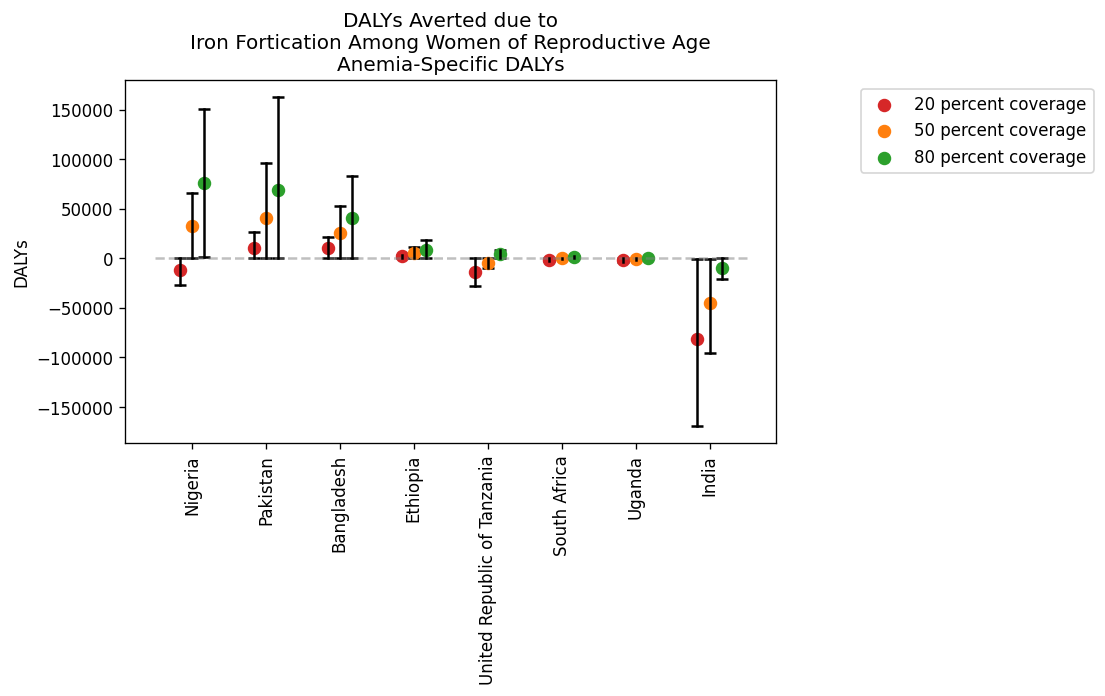

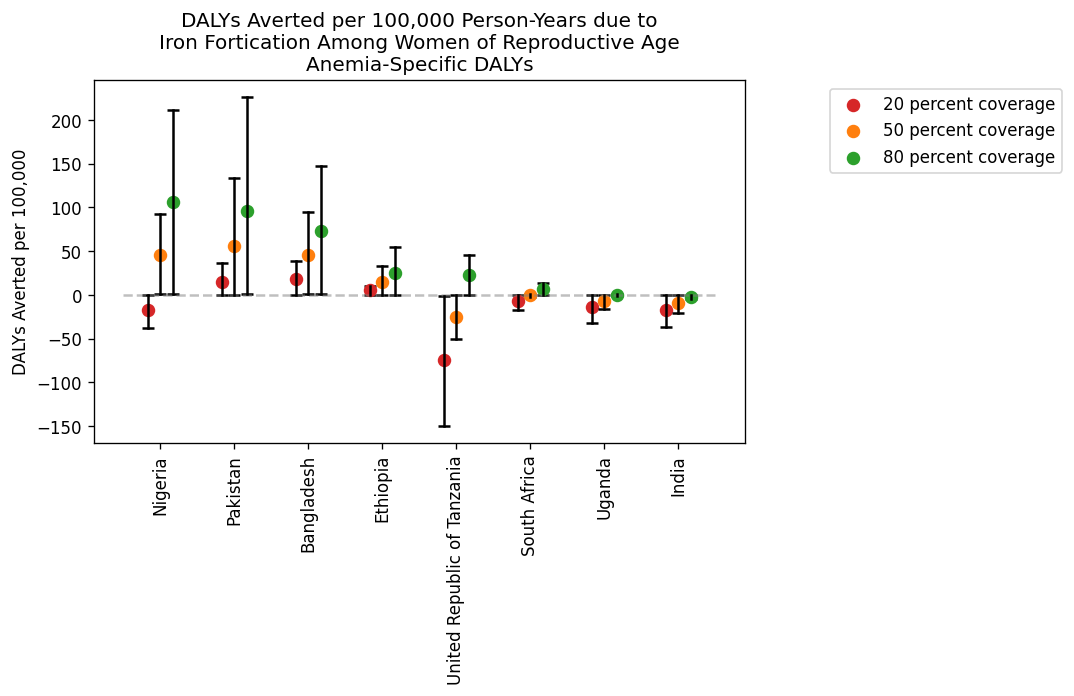

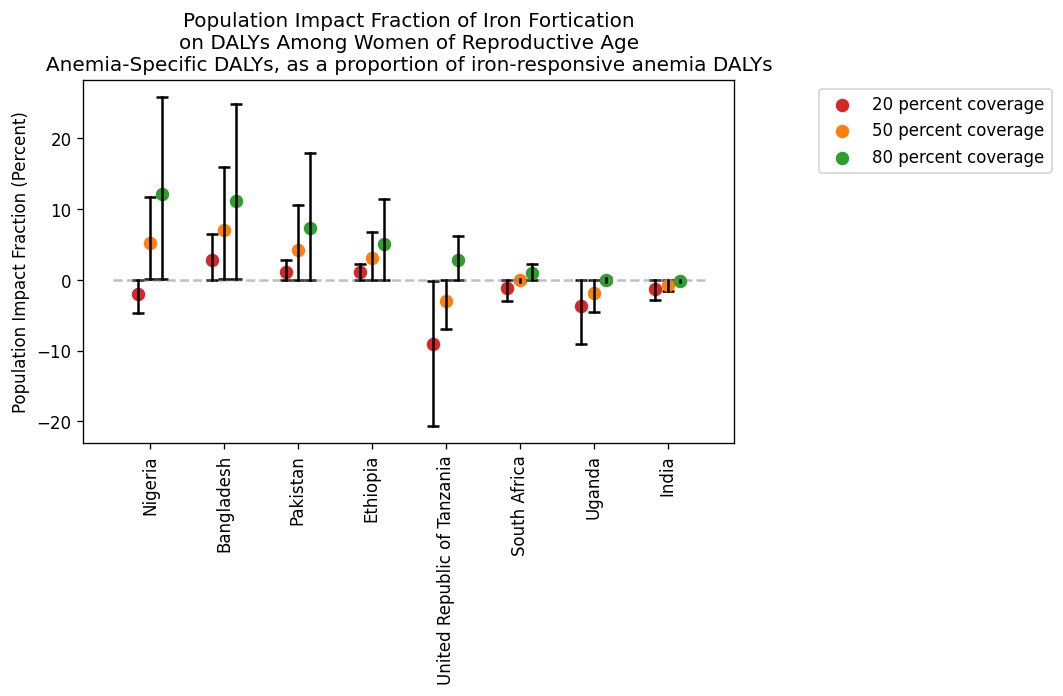

In [47]:
make_dot_plots(
    anemia_counts_averted, 
    'Iron', 
    'counts', 
    coverage_levels, 'Anemia-Specific DALYs', 
    'iron_wra_anemia_counts_averted', True)

make_dot_plots(
    anemia_rates_averted, 
    'Iron', 
    'rates', 
    coverage_levels, 'Anemia-Specific DALYs', 
    'iron_wra_anemia_rates_averted', True)

make_dot_plots(
    anemia_pifs, 
    'Iron', 
    'pifs', 
    coverage_levels, 'Anemia-Specific DALYs, as a proportion of iron-responsive anemia DALYs', 
    'iron_wra_anemia_pif', True)

# MATERNAL DISORDERS

In [23]:
rr = get_draws('rei_id',
                 95,
                 source='rr',
                 location_id=location_ids,
                 age_group_id=age_group_ids,
                 sex_id=sex_ids,
                 year_id=2019,
                 gbd_round_id=6,
                 decomp_step='step4'
                 )
rr = rr.loc[rr.cause_id==367].set_index(['sex_id','age_group_id'])
rr = rr.drop(columns=[c for c in rr.columns if 'draw' not in c])
rr

/ihme/code/central_comp/miniconda_svc-ccomp/envs/v107/lib/python3.7/site-packages/get_draws/sources/rr.py:256: UserWarning: RRs draws returned for rei_id = 95 have location_id(s) = 1 where 179, 163, 214, 161, 165, 190, 189, 196 were requested.
  ", ".join(str(hf) for hf in hdf_filters['location_id'])


draw_0    draw_1    draw_2    draw_3    draw_4  \
sex_id age_group_id                                                     
2      8             1.212408  1.350076  1.086644  1.219068  1.261495   
       13            1.212408  1.350076  1.086644  1.219068  1.261495   
       11            1.212408  1.350076  1.086644  1.219068  1.261495   
       10            1.212408  1.350076  1.086644  1.219068  1.261495   
       9             1.212408  1.350076  1.086644  1.219068  1.261495   
       12            1.212408  1.350076  1.086644  1.219068  1.261495   
       14            1.212408  1.350076  1.086644  1.219068  1.261495   
       7             1.212408  1.350076  1.086644  1.219068  1.261495   
       15            1.212408  1.350076  1.086644  1.219068  1.261495   

                       draw_5    draw_6    draw_7   draw_8    draw_9  ...  \
sex_id age_group_id                                                   ...   
2      8             1.286287  1.092801  1.212885  1.19206  1.194871  ...   
       13            1.286287  1.092801  1.212885  1.19206  1.194871  ...   
       11            1.286287  1.092801  1.212885  1.19206  1.194871  ...   
       10            1.286287  1.092801  1.212885  1.19206  1.194871  ...   
       9             1.286287  1.092801  1.212885  1.19206  1.194871  ...   
       12            1.286287  1.092801  1.212885  1.19206  1.194871  ...   
       14            1.286287  1.092801  1.212885  1.19206  1.194871  ...   
       7             1.286287  1.092801  1.212885  1.19206  1.194871  ...   
       15            1.286287  1.092801  1.212885  1.19206  1.194871  ...   

                     draw_990  draw_991  draw_992  draw_993  draw_994  \
sex_id age_group_id                                                     
2      8             1.189681  1.315712   1.28604  1.257695  1.216908   
       13            1.189681  1.315712   1.28604  1.257695  1.216908   
       11            1.189681  1.315712   1.28604  1.257695  1.216908   
       10            1.189681  1.315712   1.28604  1.257695  1.216908   
       9             1.189681  1.315712   1.28604  1.257695  1.216908   
       12            1.189681  1.315712   1.28604  1.257695  1.216908   
       14            1.189681  1.315712   1.28604  1.257695  1.216908   
       7             1.189681  1.315712   1.28604  1.257695  1.216908   
       15            1.189681  1.315712   1.28604  1.257695  1.216908   

                     draw_995  draw_996  draw_997  draw_998  draw_999  
sex_id age_group_id                                                    
2      8             1.177559  1.315347  1.221176  1.276526  1.243538  
       13            1.177559  1.315347  1.221176  1.276526  1.243538  
       11            1.177559  1.315347  1.221176  1.276526  1.243538  
       10            1.177559  1.315347  1.221176  1.276526  1.243538  
       9             1.177559  1.315347  1.221176  1.276526  1.243538  
       12            1.177559  1.315347  1.221176  1.276526  1.243538  
       14            1.177559  1.315347  1.221176  1.276526  1.243538  
       7             1.177559  1.315347  1.221176  1.276526  1.243538  
       15            1.177559  1.315347  1.221176  1.276526  1.243538  

[9 rows x 1000 columns]

In [24]:
baseline_hgb = get_draws('modelable_entity_id',
                    10487,
                    source='epi',
                    location_id=location_ids,
                    age_group_id=age_group_ids,
                    sex_id=sex_ids,
                    year_id=2019,
                    gbd_round_id=6,
                    decomp_step='step4',
                    status='best')
baseline_hgb = baseline_hgb.set_index(['location_id','sex_id','age_group_id'])
baseline_hgb = baseline_hgb.drop(columns=[c for c in baseline_hgb.columns if 'draw' not in c])
baseline_hgb.head()

draw_0      draw_1     draw_10  \
location_id sex_id age_group_id                                       
161         2      7             131.576669  130.006851  126.753823   
                   8             118.922773  126.221582  123.354380   
                   9             119.445416  119.744885  123.663548   
                   10            125.283728  125.009121  119.397039   
                   11            125.122521  121.147369  124.487696   

                                   draw_100    draw_101    draw_102  \
location_id sex_id age_group_id                                       
161         2      7             128.018065  133.273591  131.115555   
                   8             126.262134  124.932018  122.562494   
                   9             124.283216  118.579743  124.817976   
                   10            122.817539  123.870315  121.480207   
                   11            128.703954  127.822311  125.583439   

                                   draw_103    draw_104    draw_105  \
location_id sex_id age_group_id                                       
161         2      7             130.538169  127.788556  127.888119   
                   8             124.733401  123.766130  126.417171   
                   9             123.868556  121.465009  121.658608   
                   10            122.020435  124.570332  124.744182   
                   11            122.830292  124.109611  122.808416   

                                   draw_106  ...    draw_990    draw_991  \
location_id sex_id age_group_id              ...                           
161         2      7             134.269665  ...  132.629892  127.563386   
                   8             128.350657  ...  128.983925  125.823625   
                   9             119.139191  ...  127.191962  121.699027   
                   10            119.359498  ...  121.166555  119.789437   
                   11            123.786324  ...  114.836797  125.800045   

                                   draw_992    draw_993    draw_994  \
location_id sex_id age_group_id                                       
161         2      7             131.561974  128.479080  130.254982   
                   8             128.289240  130.669737  119.897130   
                   9             120.712246  121.153322  121.370690   
                   10            125.065134  124.389494  121.221193   
                   11            115.827505  125.078032  120.858680   

                                   draw_995    draw_996    draw_997  \
location_id sex_id age_group_id                                       
161         2      7             130.120093  132.948881  131.693836   
                   8             127.467974  124.626547  123.436502   
                   9             125.672017  124.850055  120.869506   
                   10            121.139373  124.053072  125.456108   
                   11            124.079560  127.209902  126.128345   

                                   draw_998    draw_999  
location_id sex_id age_group_id                          
161         2      7             129.286983  129.131233  
                   8             123.562551  128.478574  
                   9             120.472913  125.833589  
                   10            120.019112  122.695076  
                   11            122.630509  120.700463  

[5 rows x 1000 columns]

In [25]:
hgb_diff = (((mean_hgb - baseline_hgb) / 10)
            .reset_index()
            .set_index(['sex_id','age_group_id','location_id','coverage_level','year']))
hgb_diff.head()

draw_0    draw_1  \
sex_id age_group_id location_id coverage_level year                         
2      7            161         baseline       NaN     0.000000  0.000000   
                                0.2            2021.0  0.000000  0.000000   
                                0.5            2021.0  0.000000  0.000000   
                                0.8            2021.0  0.000000  0.000000   
                                0.2            2022.0  0.009368  0.005101   

                                                        draw_10  draw_100  \
sex_id age_group_id location_id coverage_level year                         
2      7            161         baseline       NaN     0.000000  0.000000   
                                0.2            2021.0  0.000000  0.000000   
                                0.5            2021.0  0.000000  0.000000   
                                0.8            2021.0  0.000000  0.000000   
                                0.2            2022.0  0.003708  0.003341   

                                                       draw_101  draw_102  \
sex_id age_group_id location_id coverage_level year                         
2      7            161         baseline       NaN     0.000000  0.000000   
                                0.2            2021.0  0.000000  0.000000   
                                0.5            2021.0  0.000000  0.000000   
                                0.8            2021.0  0.000000  0.000000   
                                0.2            2022.0  0.007529  0.006839   

                                                       draw_103  draw_104  \
sex_id age_group_id location_id coverage_level year                         
2      7            161         baseline       NaN     0.000000  0.000000   
                                0.2            2021.0  0.000000  0.000000   
                                0.5            2021.0  0.000000  0.000000   
                                0.8            2021.0  0.000000  0.000000   
                                0.2            2022.0  0.001659  0.008703   

                                                       draw_105  draw_106  \
sex_id age_group_id location_id coverage_level year                         
2      7            161         baseline       NaN     0.000000  0.000000   
                                0.2            2021.0  0.000000  0.000000   
                                0.5            2021.0  0.000000  0.000000   
                                0.8            2021.0  0.000000  0.000000   
                                0.2            2022.0  0.004078  0.009637   

                                                       ...  draw_990  \
sex_id age_group_id location_id coverage_level year    ...             
2      7            161         baseline       NaN     ...   0.00000   
                                0.2            2021.0  ...   0.00000   
                                0.5            2021.0  ...   0.00000   
                                0.8            2021.0  ...   0.00000   
                                0.2            2022.0  ...   0.00517   

                                                       draw_991  draw_992  \
sex_id age_group_id location_id coverage_level year                         
2      7            161         baseline       NaN     0.000000  0.000000   
                                0.2            2021.0  0.000000  0.000000   
                                0.5            2021.0  0.000000  0.000000   
                                0.8            2021.0  0.000000  0.000000   
                                0.2            2022.0  0.003883  0.009959   

                                                       draw_993  draw_994  \
sex_id age_group_id location_id coverage_level year                         
2      7            161         baseline       NaN     0.000000  0.000000   
                                0.2            2021.0  0.000000  0.000000   
    

In [26]:
import math
frac_reduction = ((1 / math.e ** (np.log(rr) * hgb_diff))
                  .reset_index()
                  .set_index(['location_id','sex_id','age_group_id','coverage_level','year']))
frac_reduction.head()

draw_0   draw_1  \
location_id sex_id age_group_id coverage_level year                        
161         2      7            baseline       NaN     1.000000  1.00000   
                                0.2            2021.0  1.000000  1.00000   
                                0.5            2021.0  1.000000  1.00000   
                                0.8            2021.0  1.000000  1.00000   
                                0.2            2022.0  0.998197  0.99847   

                                                       draw_10  draw_100  \
location_id sex_id age_group_id coverage_level year                        
161         2      7            baseline       NaN     1.00000  1.000000   
                                0.2            2021.0  1.00000  1.000000   
                                0.5            2021.0  1.00000  1.000000   
                                0.8            2021.0  1.00000  1.000000   
                                0.2            2022.0  0.99893  0.998977   

                                                       draw_101  draw_102  \
location_id sex_id age_group_id coverage_level year                         
161         2      7            baseline       NaN     1.000000  1.000000   
                                0.2            2021.0  1.000000  1.000000   
                                0.5            2021.0  1.000000  1.000000   
                                0.8            2021.0  1.000000  1.000000   
                                0.2            2022.0  0.998646  0.997943   

                                                       draw_103  draw_104  \
location_id sex_id age_group_id coverage_level year                         
161         2      7            baseline       NaN     1.000000  1.000000   
                                0.2            2021.0  1.000000  1.000000   
                                0.5            2021.0  1.000000  1.000000   
                                0.8            2021.0  1.000000  1.000000   
                                0.2            2022.0  0.999656  0.998555   

                                                       draw_105  draw_106  \
location_id sex_id age_group_id coverage_level year                         
161         2      7            baseline       NaN     1.000000   1.00000   
                                0.2            2021.0  1.000000   1.00000   
                                0.5            2021.0  1.000000   1.00000   
                                0.8            2021.0  1.000000   1.00000   
                                0.2            2022.0  0.999185   0.99707   

                                                       ...  draw_990  \
location_id sex_id age_group_id coverage_level year    ...             
161         2      7            baseline       NaN     ...  1.000000   
                                0.2            2021.0  ...  1.000000   
                                0.5            2021.0  ...  1.000000   
                                0.8            2021.0  ...  1.000000   
                                0.2            2022.0  ...  0.999103   

                                                       draw_991  draw_992  \
location_id sex_id age_group_id coverage_level year                         
161         2      7            baseline       NaN     1.000000  1.000000   
                                0.2            2021.0  1.000000  1.000000   
                                0.5            2021.0  1.000000  1.000000   
                                0.8            2021.0  1.000000  1.000000   
                                0.2            2022.0  0.998935  0.997498   

                                                       draw_993  draw_994  \
location_id sex_id age_group_id coverage_level year                         
161         2      7            baseline       NaN     1.000000  1.000000   
                                0.2            2021.0  1.000000  1.000000   
                  

In [27]:
maternal_ylds = get_draws('cause_id',
                367,
                source='como',
                location_id=location_ids,
                age_group_id=age_group_ids,
                measure_id=3, #ylds
                metric_id=3, #rate
                sex_id=sex_ids,
                year_id=2019,
                gbd_round_id=6,
                decomp_step='step5')
pop = get_population(location_id=location_ids,
                    sex_id=sex_ids,
                    age_group_id=age_group_ids,
                    gbd_round_id=6,
                    decomp_step='step4')
maternal_ylds = maternal_ylds.merge(pop, on=['location_id','sex_id','age_group_id'])
for i in list(range(0,1000)):
    maternal_ylds[f'draw_{i}'] = maternal_ylds[f'draw_{i}'] * maternal_ylds['population']

maternal_ylds = maternal_ylds.set_index(['location_id','sex_id','age_group_id'])
maternal_ylds = maternal_ylds.drop(columns=[c for c in maternal_ylds.columns if 'draw' not in c])
maternal_ylds.head()

draw_0       draw_1      draw_10  \
location_id sex_id age_group_id                                          
161         2      7                5.605376     8.009380     7.333826   
                   8             1344.500056  1107.740419   912.220394   
                   9             1765.329123  1577.511233  2813.178844   
                   10            1490.287741  1314.014623  1740.456132   
                   11             842.729144   989.167025   519.975834   

                                    draw_100     draw_101     draw_102  \
location_id sex_id age_group_id                                          
161         2      7                5.814282     4.073612     2.328328   
                   8              737.335694   900.820253   589.578043   
                   9             2279.364557  2262.548268  1866.021755   
                   10            2689.880526  2470.259898  2107.677054   
                   11             984.805465   997.771802   742.237976   

                                    draw_103     draw_104     draw_105  \
location_id sex_id age_group_id                                          
161         2      7                4.052449     5.247648    11.594694   
                   8              869.968899   860.883772  1424.383129   
                   9             1686.718315  1665.745547  1532.010958   
                   10            2387.609646  1493.157348  1298.330678   
                   11            1740.497068  1077.609904   814.939159   

                                    draw_106  ...     draw_990     draw_991  \
location_id sex_id age_group_id               ...                             
161         2      7                1.674789  ...     5.004973    10.181300   
                   8              454.304098  ...   762.226006  1834.702186   
                   9             1501.257956  ...  2017.194024  3963.503810   
                   10            1569.675844  ...  2039.670318  2300.703675   
                   11             725.805914  ...  1622.155190  1015.860766   

                                    draw_992     draw_993     draw_994  \
location_id sex_id age_group_id                                          
161         2      7                5.830722     5.272072     4.164612   
                   8             1152.058421   962.772322  1037.884899   
                   9             2985.787414  2242.374835  1610.068020   
                   10            1487.892885  1340.805055  1985.919450   
                   11            1329.299619   913.983494  1253.396313   

                                    draw_995    draw_996     draw_997  \
location_id sex_id age_group_id                                         
161         2      7                5.941655    2.277239     4.174688   
                   8             1123.577125  532.553290  1081.952696   
                   9             1985.849737  676.877154  1985.756166   
                   10            2110.341707  853.958783  1170.068015   
                   11            1286.996797  356.678600   721.952649   

                                    draw_998     draw_999  
location_id sex_id age_group_id                            
161         2      7                5.193143     4.081655  
                   8              629.198571   674.430309  
                   9             1296.365569  1167.186594  
                   10            1788.516376  1266.866897  
                   11            1133.566478  1096.926563  

[5 rows x 1000 columns]

In [28]:
maternal_ylls = get_draws('cause_id',
                367,
                source='codcorrect',
                location_id=location_ids,
                age_group_id=age_group_ids,
                measure_id=4,
                metric_id=1,
                sex_id=sex_ids,
                year_id=2019,
                gbd_round_id=6,
                decomp_step='step5',
                status='latest')

maternal_ylls = maternal_ylls.set_index(['location_id','sex_id','age_group_id'])
maternal_ylls = maternal_ylls.drop(columns=[c for c in maternal_ylls.columns if 'draw' not in c])
maternal_ylls.head()

draw_0        draw_1       draw_10  \
location_id sex_id age_group_id                                             
161         2      7              3068.047648   2364.327119   3922.304359   
                   8             18962.348882  21596.048676  21293.496575   
                   9             25164.107224  22388.625373  29331.724218   
                   10            37898.097233  23710.646321  35147.700853   
                   11            27433.664515  27426.465759  24171.913543   

                                     draw_100      draw_101      draw_102  \
location_id sex_id age_group_id                                             
161         2      7               923.794922   1670.581500   1656.338574   
                   8             16910.901854  15743.915644  16241.869392   
                   9             20420.268860  25111.758872  18465.592966   
                   10            24373.717461  24807.059235  21534.316597   
                   11            18920.636280  15188.663063  18226.329983   

                                     draw_103      draw_104      draw_105  \
location_id sex_id age_group_id                                             
161         2      7              3138.454117   1803.426682    851.240253   
                   8             20120.567835  18655.726674  14816.830220   
                   9             23704.972885  31346.072690  16562.725862   
                   10            20312.623054  31217.164695  17993.288594   
                   11            19295.105818  19555.936627  15140.400706   

                                     draw_106  ...      draw_990  \
location_id sex_id age_group_id                ...                 
161         2      7              1088.780358  ...   1450.609836   
                   8             19170.010126  ...  15650.846125   
                   9             30906.271428  ...  22451.378895   
                   10            20065.291936  ...  40254.851345   
                   11            14249.729124  ...  16283.960768   

                                     draw_991      draw_992      draw_993  \
location_id sex_id age_group_id                                             
161         2      7              2573.142741   4044.113254   1626.659647   
                   8             18193.248406  24143.655907  25896.954511   
                   9             33969.990452  33068.018900  36303.059881   
                   10            28645.566362  23846.460131  21684.140433   
                   11            21344.719381  21011.697938  23806.006571   

                                     draw_994      draw_995      draw_996  \
location_id sex_id age_group_id                                             
161         2      7              2620.032733    804.348015   1819.398528   
                   8             15678.732041  20533.561141  13144.864341   
                   9             31474.243177  30321.996209  19828.804040   
                   10            36525.390496  33818.676992  24729.399673   
                   11            23126.964951  28649.748059  17567.525586   

                                     draw_997      draw_998      draw_999  
location_id sex_id age_group_id                                            
161         2      7              2005.979635   4828.300725   2945.854187  
                   8             23042.334383  25016.081946  25898.720461  
                   9             36424.115556  33251.534751  20521.905058  
                   10            32485.010665  22935.644502  24126.705045  
                   11            23441.172139  21935.538490  13213.505474  

[5 rows x 1000 columns]

In [29]:
maternal_dalys = maternal_ylds + maternal_ylls
maternal_dalys.head()

draw_0        draw_1       draw_10  \
location_id sex_id age_group_id                                             
161         2      7              3073.653023   2372.336498   3929.638186   
                   8             20306.848938  22703.789095  22205.716969   
                   9             26929.436347  23966.136606  32144.903063   
                   10            39388.384974  25024.660944  36888.156985   
                   11            28276.393659  28415.632784  24691.889377   

                                     draw_100      draw_101      draw_102  \
location_id sex_id age_group_id                                             
161         2      7               929.609203   1674.655112   1658.666902   
                   8             17648.237549  16644.735896  16831.447435   
                   9             22699.633417  27374.307140  20331.614721   
                   10            27063.597987  27277.319133  23641.993652   
                   11            19905.441745  16186.434865  18968.567959   

                                     draw_103      draw_104      draw_105  \
location_id sex_id age_group_id                                             
161         2      7              3142.506566   1808.674330    862.834947   
                   8             20990.536734  19516.610446  16241.213349   
                   9             25391.691201  33011.818237  18094.736821   
                   10            22700.232700  32710.322043  19291.619272   
                   11            21035.602887  20633.546531  15955.339865   

                                     draw_106  ...      draw_990  \
location_id sex_id age_group_id                ...                 
161         2      7              1090.455147  ...   1455.614809   
                   8             19624.314224  ...  16413.072132   
                   9             32407.529385  ...  24468.572919   
                   10            21634.967780  ...  42294.521663   
                   11            14975.535038  ...  17906.115958   

                                     draw_991      draw_992      draw_993  \
location_id sex_id age_group_id                                             
161         2      7              2583.324040   4049.943976   1631.931718   
                   8             20027.950592  25295.714328  26859.726834   
                   9             37933.494262  36053.806314  38545.434716   
                   10            30946.270037  25334.353016  23024.945488   
                   11            22360.580147  22340.997558  24719.990065   

                                     draw_994      draw_995      draw_996  \
location_id sex_id age_group_id                                             
161         2      7              2624.197344    810.289670   1821.675767   
                   8             16716.616941  21657.138266  13677.417632   
                   9             33084.311197  32307.845945  20505.681194   
                   10            38511.309945  35929.018699  25583.358456   
                   11            24380.361263  29936.744856  17924.204186   

                                     draw_997      draw_998      draw_999  
location_id sex_id age_group_id                                            
161         2      7              2010.154323   4833.493867   2949.935841  
                   8             24124.287079  25645.280516  26573.150771  
                   9             38409.871722  34547.900321  21689.091653  
                   10            33655.078680  24724.160878  25393.571942  
                   11            24163.124788  23069.104967  14310.432038  

[5 rows x 1000 columns]

In [30]:
counterfactual_maternal_dalys = maternal_dalys * frac_reduction
counterfactual_maternal_dalys = (counterfactual_maternal_dalys.groupby(['location_id','coverage_level','year']).sum())
maternal_counts_averted = maternal_dalys.groupby('location_id').sum() - counterfactual_maternal_dalys
maternal_counts_averted.head()

draw_0      draw_1     draw_10  \
location_id coverage_level year                                          
161         0.2            2021.0     0.000000    0.000000    0.000000   
                           2022.0   260.000805  208.581694  153.952243   
                           2023.0  1037.194217  832.413861  614.821709   
                           2024.0  1037.194217  832.413861  614.821709   
                           2025.0  1037.194217  832.413861  614.821709   

                                     draw_100    draw_101    draw_102  \
location_id coverage_level year                                         
161         0.2            2021.0    0.000000    0.000000    0.000000   
                           2022.0  120.864163  163.885565  210.167224   
                           2023.0  482.715620  654.212516  838.078361   
                           2024.0  482.715620  654.212516  838.078361   
                           2025.0  482.715620  654.212516  838.078361   

                                     draw_103    draw_104    draw_105  \
location_id coverage_level year                                         
161         0.2            2021.0    0.000000    0.000000    0.000000   
                           2022.0   41.027644  205.061863   81.049913   
                           2023.0  164.025996  818.470941  323.803417   
                           2024.0  164.025996  818.470941  323.803417   
                           2025.0  164.025996  818.470941  323.803417   

                                      draw_106  ...    draw_990    draw_991  \
location_id coverage_level year                 ...                           
161         0.2            2021.0     0.000000  ...    0.000000    0.000000   
                           2022.0   357.824356  ...  116.834780  158.621942   
                           2023.0  1425.018799  ...  466.710344  633.474996   
                           2024.0  1425.018799  ...  466.710344  633.474996   
                           2025.0  1425.018799  ...  466.710344  633.474996   

                                      draw_992     draw_993    draw_994  \
location_id coverage_level year                                           
161         0.2            2021.0     0.000000     0.000000    0.000000   
                           2022.0   384.661534   360.609078  110.640453   
                           2023.0  1532.880768  1436.985149  442.095246   
                           2024.0  1532.880768  1436.985149  442.095246   
                           2025.0  1532.880768  1436.985149  442.095246   

                                     draw_995    draw_996    draw_997  \
location_id coverage_level year                                         
161         0.2            2021.0    0.000000    0.000000    0.000000   
                           2022.0  144.011653  224.038557  141.921310   
                           2023.0  575.232309  893.575310  566.942458   
                           2024.0  575.232309  893.575310  566.942458   
                           2025.0  575.232309  893.575310  566.942458   

                                     draw_998    draw_999  
location_id coverage_level year                            
161         0.2            2021.0    0.000000    0.000000  
                           2022.0  133.160370   67.426224  
                           2023.0  531.880511  269.486131  
                           2024.0  531.880511  269.486131  
                           2025.0  531.880511  269.486131  

[5 rows x 1000 columns]

In [31]:
maternal_rates_averted = (maternal_counts_averted.reset_index()
                 .merge(pop.groupby('location_id', as_index=False).sum().drop(columns='year_id'), 
                        on='location_id'))
for i in list(range(0,1000)):
    maternal_rates_averted[f'draw_{i}'] = (maternal_rates_averted[f'draw_{i}'] / maternal_rates_averted['population']) * 100_000
maternal_rates_averted = maternal_rates_averted.set_index(['location_id','coverage_level','year'])
maternal_rates_averted = maternal_rates_averted.drop(columns=[c for c in maternal_rates_averted.columns if 'draw' not in c])
maternal_rates_averted.head()

draw_0    draw_1   draw_10  draw_100  \
location_id coverage_level year                                             
161         0.2            2021.0  0.000000  0.000000  0.000000  0.000000   
                           2022.0  0.462411  0.370962  0.273804  0.214957   
                           2023.0  1.844646  1.480445  1.093458  0.858508   
                           2024.0  1.844646  1.480445  1.093458  0.858508   
                           2025.0  1.844646  1.480445  1.093458  0.858508   

                                   draw_101  draw_102  draw_103  draw_104  \
location_id coverage_level year                                             
161         0.2            2021.0  0.000000  0.000000  0.000000  0.000000   
                           2022.0  0.291470  0.373782  0.072968  0.364702   
                           2023.0  1.163515  1.490520  0.291720  1.455648   
                           2024.0  1.163515  1.490520  0.291720  1.455648   
                           2025.0  1.163515  1.490520  0.291720  1.455648   

                                   draw_105  draw_106  ...  draw_990  \
location_id coverage_level year                        ...             
161         0.2            2021.0  0.000000  0.000000  ...  0.000000   
                           2022.0  0.144147  0.636389  ...  0.207790   
                           2023.0  0.575883  2.534391  ...  0.830043   
                           2024.0  0.575883  2.534391  ...  0.830043   
                           2025.0  0.575883  2.534391  ...  0.830043   

                                   draw_991  draw_992  draw_993  draw_994  \
location_id coverage_level year                                             
161         0.2            2021.0  0.000000  0.000000  0.000000  0.000000   
                           2022.0  0.282109  0.684119  0.641342  0.196774   
                           2023.0  1.126633  2.726223  2.555673  0.786265   
                           2024.0  1.126633  2.726223  2.555673  0.786265   
                           2025.0  1.126633  2.726223  2.555673  0.786265   

                                   draw_995  draw_996  draw_997  draw_998  \
location_id coverage_level year                                             
161         0.2            2021.0  0.000000  0.000000  0.000000  0.000000   
                           2022.0  0.256124  0.398452  0.252407  0.236825   
                           2023.0  1.023049  1.589221  1.008305  0.945948   
                           2024.0  1.023049  1.589221  1.008305  0.945948   
                           2025.0  1.023049  1.589221  1.008305  0.945948   

                                   draw_999  
location_id coverage_level year              
161         0.2            2021.0  0.000000  
                           2022.0  0.119917  
                           2023.0  0.479280  
                           2024.0  0.479280  
                           2025.0  0.479280  

[5 rows x 1000 columns]

In [32]:
iron_attributable_maternal_disorder_burden = get_draws(gbd_id_type=['rei_id','cause_id'],
                                                      gbd_id=[95,367],
                                                      location_id=location_ids,
                                                      sex_id=sex_ids,
                                                      age_group_id=age_group_ids,
                                                      measure_id=2, # dalys
                                                      metric_id=1, # number
                                                      source='burdenator',
                                                      decomp_step='step5',
                                                      gbd_round_id=6,
                                                      year_id=2019)
iron_attributable_maternal_disorder_burden = iron_attributable_maternal_disorder_burden.groupby('location_id').sum()
iron_attributable_maternal_disorder_burden = iron_attributable_maternal_disorder_burden.drop(columns=[c for c in iron_attributable_maternal_disorder_burden.columns if 'draw' not in c])
iron_attributable_maternal_disorder_burden = (iron_attributable_maternal_disorder_burden.reset_index()
                                              .merge(pop.groupby('location_id').sum().reset_index(),
                                                     on='location_id'))
for i in list(range(0,1000)):
    iron_attributable_maternal_disorder_burden[f'draw_{i}'] = iron_attributable_maternal_disorder_burden[f'draw_{i}'] / iron_attributable_maternal_disorder_burden['population']
iron_attributable_maternal_disorder_burden = iron_attributable_maternal_disorder_burden.set_index(['location_id'])
iron_attributable_maternal_disorder_burden = iron_attributable_maternal_disorder_burden.drop(columns=[c for c in iron_attributable_maternal_disorder_burden.columns if 'draw' not in c])

iron_attributable_maternal_disorder_burden

,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,draw_105,draw_106,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
location_id,,,,,,,,,,,,,,,,,,,,,
161,0.000384,0.000573,0.000565,0.000497,0.000284,0.000408,0.000340,0.000330,0.000258,0.000510,...,0.000303,0.000573,0.000510,0.000400,0.000408,0.000328,0.000406,0.000440,0.000465,0.000352
163,0.000448,0.000637,0.000630,0.000786,0.000430,0.000694,0.000356,0.000377,0.000546,0.000714,...,0.000386,0.000743,0.000584,0.000452,0.000344,0.000384,0.000705,0.000410,0.000613,0.000568
165,0.000927,0.001274,0.001052,0.000971,0.000779,0.001226,0.000869,0.000584,0.000875,0.001168,...,0.000666,0.001024,0.001191,0.000777,0.000744,0.000564,0.001107,0.000652,0.000938,0.001070
179,0.000425,0.000683,0.000556,0.000792,0.000366,0.000668,0.000473,0.000352,0.000406,0.000526,...,0.000425,0.000716,0.000550,0.000504,0.000365,0.000403,0.000719,0.000494,0.000642,0.000461
189,0.000894,0.001106,0.001042,0.001391,0.000883,0.000918,0.000750,0.000753,0.000728,0.001021,...,0.000498,0.001108,0.001244,0.001246,0.000814,0.000744,0.001060,0.000807,0.000915,0.000645
190,0.000324,0.000341,0.000451,0.000565,0.000279,0.000376,0.000303,0.000320,0.000262,0.000467,...,0.000234,0.000481,0.000397,0.000409,0.000316,0.000263,0.000434,0.000340,0.000372,0.000251
196,0.000088,0.000180,0.000132,0.000144,0.000116,0.000152,0.000104,0.000078,0.000116,0.000168,...,0.000090,0.000176,0.000137,0.000099,0.000117,0.000110,0.000162,0.000145,0.000177,0.000116
214,0.001350,0.001030,0.001805,0.001295,0.000926,0.001066,0.000947,0.000871,0.000925,0.001039,...,0.000827,0.001104,0.001896,0.001306,0.000905,0.000696,0.001073,0.001071,0.001027,0.001650


In [33]:
maternal_disorders_pif = maternal_rates_averted / (iron_attributable_maternal_disorder_burden * 100_000) * 100
maternal_disorders_pif.head()

draw_0    draw_1   draw_10  draw_100  \
location_id coverage_level year                                             
161         0.2            2021.0  0.000000  0.000000  0.000000  0.000000   
                           2022.0  1.205563  0.647883  0.484887  0.432633   
                           2023.0  4.809226  2.585592  1.936438  1.727878   
                           2024.0  4.809226  2.585592  1.936438  1.727878   
                           2025.0  4.809226  2.585592  1.936438  1.727878   

                                   draw_101  draw_102  draw_103  draw_104  \
location_id coverage_level year                                             
161         0.2            2021.0  0.000000  0.000000  0.000000  0.000000   
                           2022.0  1.026866  0.915556  0.214823  1.104974   
                           2023.0  4.099132  3.650939  0.858850  4.410322   
                           2024.0  4.099132  3.650939  0.858850  4.410322   
                           2025.0  4.099132  3.650939  0.858850  4.410322   

                                   draw_105  draw_106  ...  draw_990  \
location_id coverage_level year                        ...             
161         0.2            2021.0  0.000000  0.000000  ...  0.000000   
                           2022.0  0.558167  1.246903  ...  0.684665   
                           2023.0  2.229938  4.965732  ...  2.734977   
                           2024.0  2.229938  4.965732  ...  2.734977   
                           2025.0  2.229938  4.965732  ...  2.734977   

                                   draw_991  draw_992  draw_993  draw_994  \
location_id coverage_level year                                             
161         0.2            2021.0  0.000000  0.000000  0.000000  0.000000   
                           2022.0  0.492330  1.340180  1.605098  0.482766   
                           2023.0  1.966178  5.340632  6.396130  1.929030   
                           2024.0  1.966178  5.340632  6.396130  1.929030   
                           2025.0  1.966178  5.340632  6.396130  1.929030   

                                   draw_995  draw_996  draw_997  draw_998  \
location_id coverage_level year                                             
161         0.2            2021.0  0.000000  0.000000  0.000000  0.000000   
                           2022.0  0.780246  0.980598  0.574064  0.508996   
                           2023.0  3.116573  3.911103  2.293250  2.033074   
                           2024.0  3.116573  3.911103  2.293250  2.033074   
                           2025.0  3.116573  3.911103  2.293250  2.033074   

                                   draw_999  
location_id coverage_level year              
161         0.2            2021.0  0.000000  
                           2022.0  0.340273  
                           2023.0  1.359989  
                           2024.0  1.359989  
                           2025.0  1.359989  

[5 rows x 1000 columns]

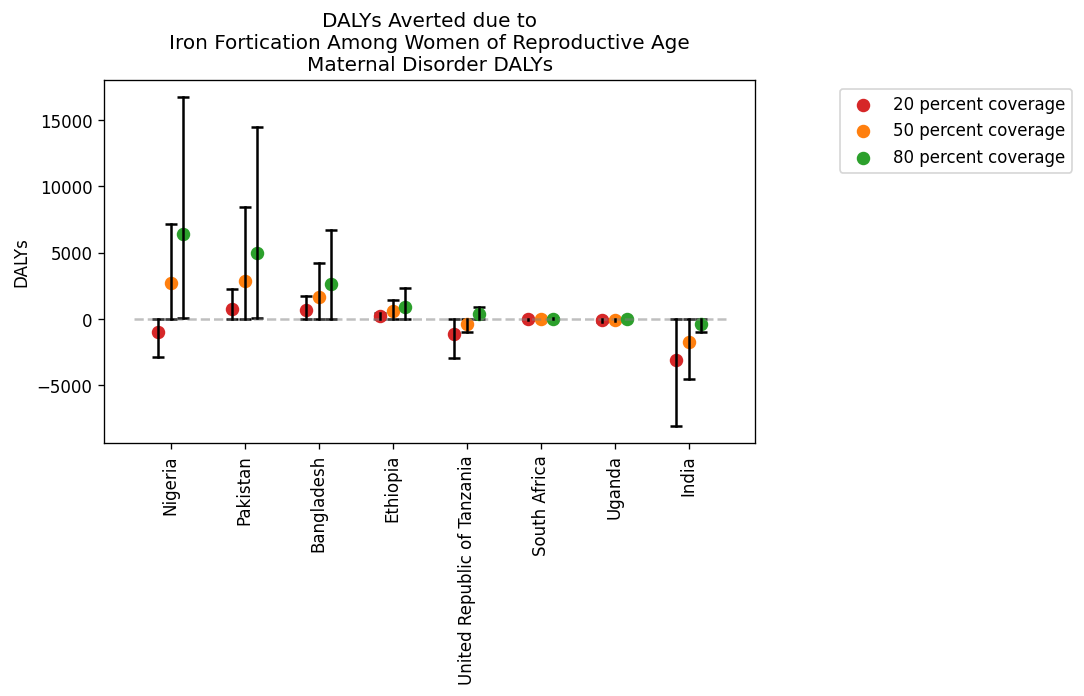

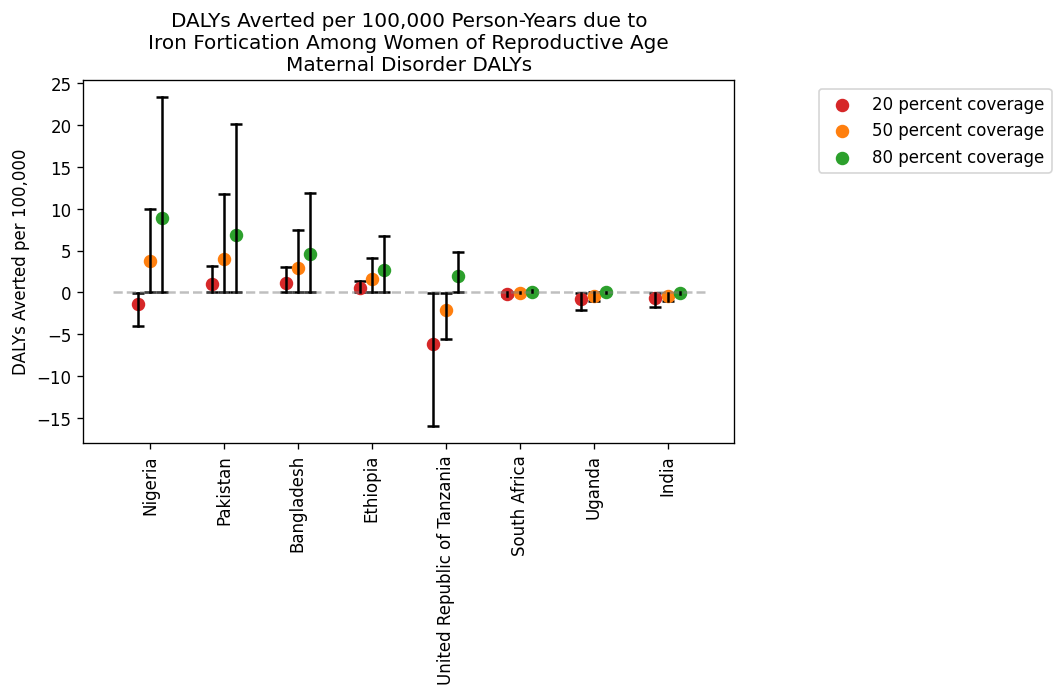

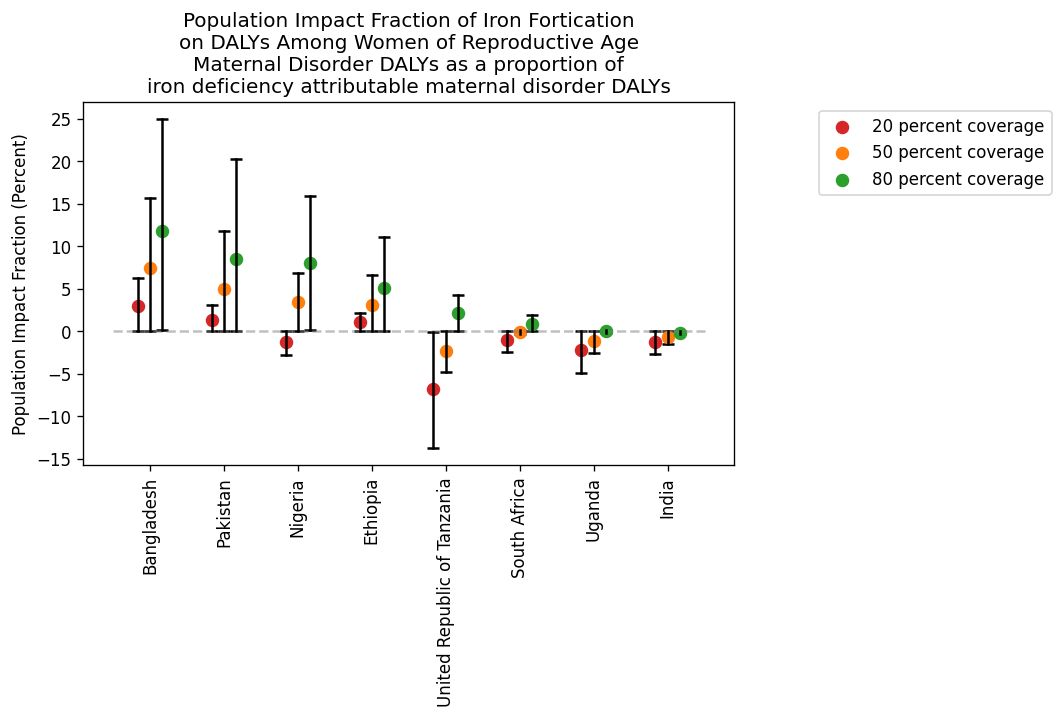

In [46]:
make_dot_plots(
    maternal_counts_averted,
    'Iron', 
    'counts', 
    coverage_levels, 'Maternal Disorder DALYs', 
    'iron_wra_maternal_disorder_counts_averted', True)
make_dot_plots(
    maternal_rates_averted,
    'Iron', 
    'rates',
    coverage_levels, 'Maternal Disorder DALYs', 
    'iron_wra_maternal_disorder_rates_averted', True)
make_dot_plots(
    maternal_disorders_pif,
    'Iron', 
    'pifs',
    coverage_levels, 'Maternal Disorder DALYs as a proportion of\niron deficiency attributable maternal disorder DALYs',
    'iron_wra_maternal_disorder_pif', True)

# OVERALL

In [35]:
overall_counts_averted = anemia_counts_averted + maternal_counts_averted
overall_rates_averted = anemia_rates_averted + maternal_rates_averted
overall_counts_averted.head()

draw                                   draw_0        draw_1      draw_10  \
location_id coverage_level year                                            
161         0.2            2021      0.000000      0.000000     0.000000   
                           2022   4825.761671   2593.357083  2047.457206   
                           2023  19117.022465  10317.914508  8156.195442   
                           2024  19117.022465  10317.914508  8156.195442   
                           2025  19117.022465  10317.914508  8156.195442   

draw                                draw_100      draw_101      draw_102  \
location_id coverage_level year                                            
161         0.2            2021     0.000000      0.000000      0.000000   
                           2022  1655.858221   3848.880181   3237.726162   
                           2023  6599.790505  15268.843391  12852.085644   
                           2024  6599.790505  15268.843391  12852.085644   
                           2025  6599.790505  15268.843391  12852.085644   

draw                                draw_103      draw_104     draw_105  \
location_id coverage_level year                                           
161         0.2            2021     0.000000      0.000000     0.000000   
                           2022   826.743618   4547.963776  1907.379679   
                           2023  3301.207192  18024.764883  7592.099114   
                           2024  3301.207192  18024.764883  7592.099114   
                           2025  3301.207192  18024.764883  7592.099114   

draw                                 draw_106  ...     draw_990     draw_991  \
location_id coverage_level year                ...                             
161         0.2            2021      0.000000  ...     0.000000     0.000000   
                           2022   4923.715269  ...  2506.264932  2025.409214   
                           2023  19501.244676  ...  9972.116685  8067.387193   
                           2024  19501.244676  ...  9972.116685  8067.387193   
                           2025  19501.244676  ...  9972.116685  8067.387193   

draw                                 draw_992      draw_993     draw_994  \
location_id coverage_level year                                            
161         0.2            2021      0.000000      0.000000     0.000000   
                           2022   5316.567969   5008.690824  2075.566352   
                           2023  21039.961574  19761.707821  8269.598122   
                           2024  21039.961574  19761.707821  8269.598122   
                           2025  21039.961574  19761.707821  8269.598122   

draw                                 draw_995      draw_996     draw_997  \
location_id coverage_level year                                            
161         0.2            2021      0.000000      0.000000     0.000000   
                           2022   2599.811011   3352.248344  2146.233975   
                           2023  10332.284692  13308.764545  8544.737485   
                           2024  10332.284692  13308.764545  8544.737485   
                           2025  10332.284692  13308.764545  8544.737485   

draw                                draw_998     draw_999  
location_id coverage_level year                            
161         0.2            2021     0.000000     0.000000  
                           2022  2243.493654  1185.251740  
                           2023  8937.174187  4727.053907  
                           2024  8937.174187  4727.053907  
                           2025  8937.174187  4727.053907  

[5 rows x 1000 columns]

In [38]:
overall_pif = overall_rates_averted / ((ira_ylds + iron_attributable_maternal_disorder_burden)) * 100
overall_pif.head()

draw                               draw_0    draw_1   draw_10  draw_100  \
location_id coverage_level year                                           
161         0.2            2021  0.000000  0.000000  0.000000  0.000000   
                           2022  1.052597  0.609075  0.575251  0.389353   
                           2023  4.169813  2.423260  2.291555  1.551853   
                           2024  4.169813  2.423260  2.291555  1.551853   
                           2025  4.169813  2.423260  2.291555  1.551853   

draw                             draw_101  draw_102  draw_103  draw_104  \
location_id coverage_level year                                           
161         0.2            2021  0.000000  0.000000  0.000000  0.000000   
                           2022  1.110170  0.872362  0.186477  1.253807   
                           2023  4.404141  3.462824  0.744608  4.969164   
                           2024  4.404141  3.462824  0.744608  4.969164   
                           2025  4.404141  3.462824  0.744608  4.969164   

draw                             draw_105  draw_106  ...  draw_990  draw_991  \
location_id coverage_level year                      ...                       
161         0.2            2021  0.000000  0.000000  ...  0.000000  0.000000   
                           2022  0.459521  1.712095  ...  0.685140  0.493512   
                           2023  1.829068  6.781055  ...  2.726087  1.965702   
                           2024  1.829068  6.781055  ...  2.726087  1.965702   
                           2025  1.829068  6.781055  ...  2.726087  1.965702   

draw                             draw_992  draw_993  draw_994  draw_995  \
location_id coverage_level year                                           
161         0.2            2021  0.000000  0.000000  0.000000  0.000000   
                           2022  1.326251  1.760021  0.520972  0.734813   
                           2023  5.248550  6.944133  2.075690  2.920328   
                           2024  5.248550  6.944133  2.075690  2.920328   
                           2025  5.248550  6.944133  2.075690  2.920328   

draw                             draw_996  draw_997  draw_998  draw_999  
location_id coverage_level year                                          
161         0.2            2021  0.000000  0.000000  0.000000  0.000000  
                           2022  1.772375  0.703440  0.643375  0.426104  
                           2023  7.036508  2.800583  2.562947  1.699400  
                           2024  7.036508  2.800583  2.562947  1.699400  
                           2025  7.036508  2.800583  2.562947  1.699400  

[5 rows x 1000 columns]

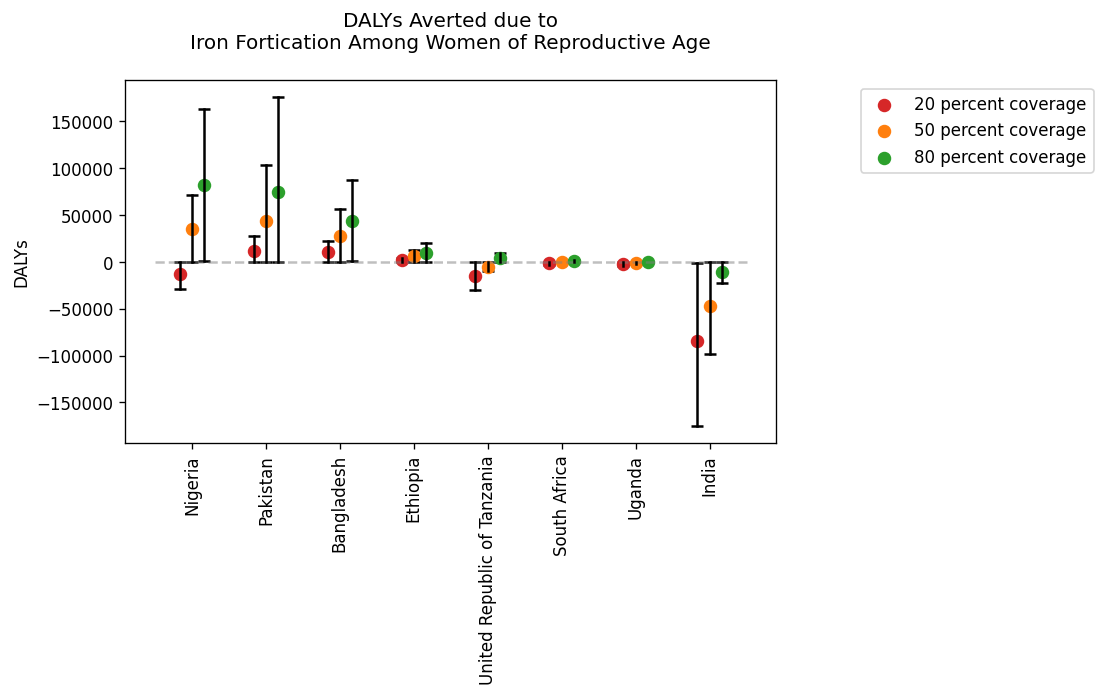

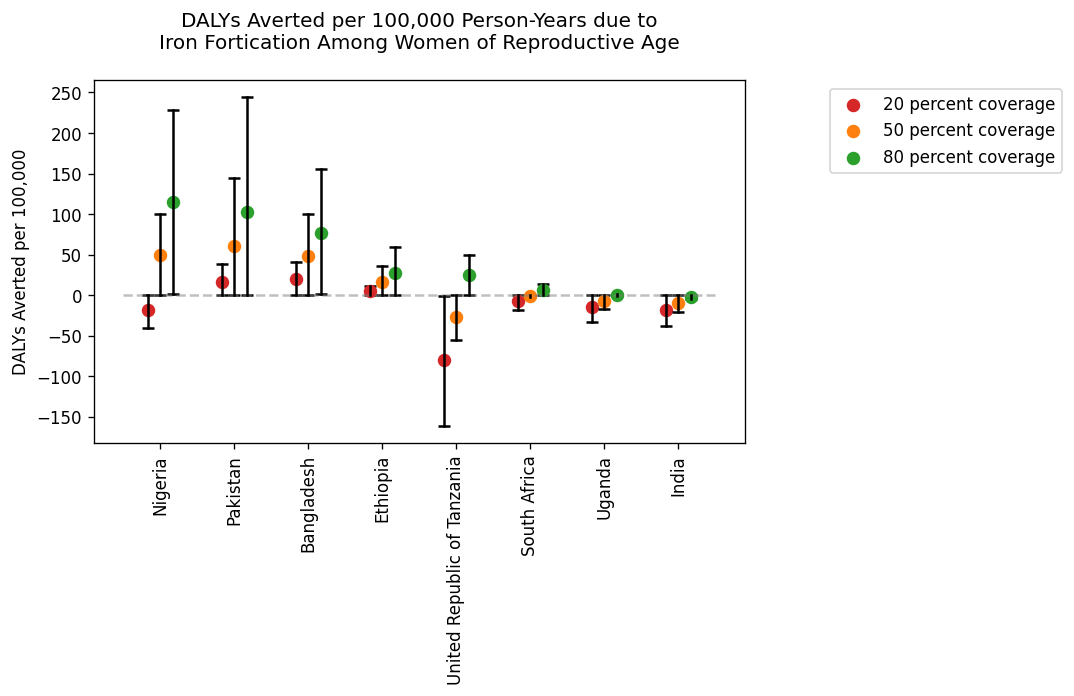

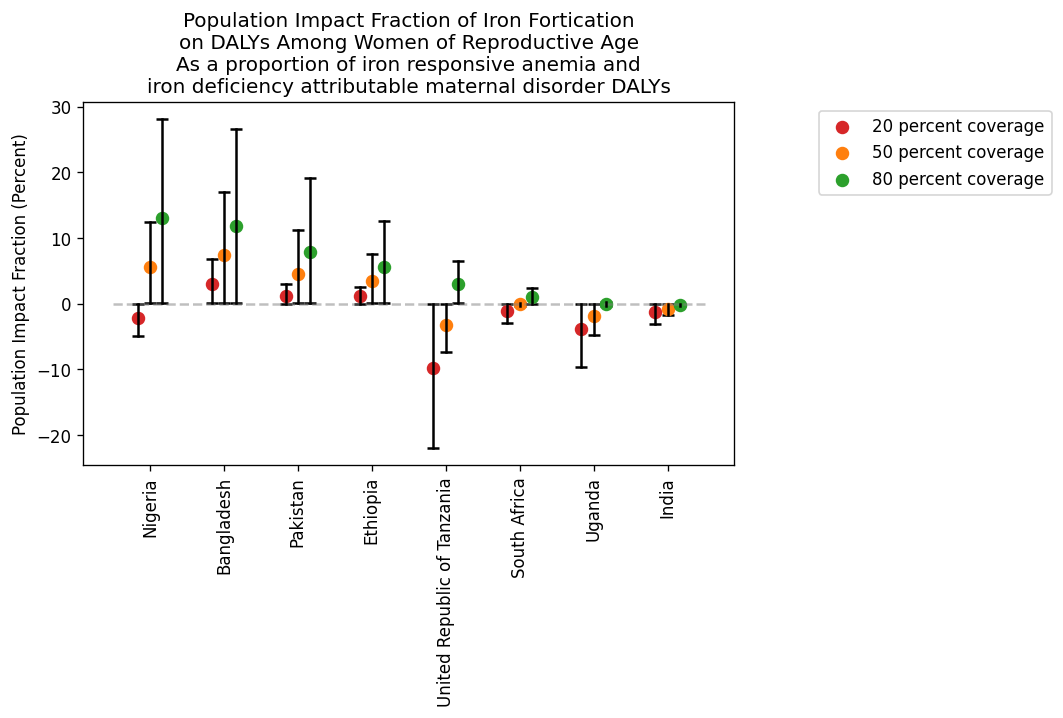

In [45]:
make_dot_plots(
    overall_counts_averted,
    'Iron', 
    'counts', 
    coverage_levels, 
    '', 
    'iron_wra_overall_counts_averted',
    True)
make_dot_plots(
    overall_rates_averted,
    'Iron', 
    'rates',
    coverage_levels, 
    '', 
    'iron_wra_overall_rates_averted',
    True)
make_dot_plots(
    overall_pif,
    'Iron', 
    'pifs',
    coverage_levels, 
    'As a proportion of iron responsive anemia and\niron deficiency attributable maternal disorder DALYs', 
    'iron_wra_overall_pif',
    True)

In [43]:
def make_dot_plots(data, nutrient, measure, coverage_levels, subtitle, output_filename, wra=False):
    """This function takes a dataframe,
    nutrient (as a string),
    and measure (as a string, either: 'rates', 'counts', or 'pifs').
    """

    f, ax = plt.subplots(figsize=(7, 4), dpi=120)
    colors = ['tab:red', 'tab:orange', 'tab:green']

    location_spacer = 0.15
    coverage_spacer = 0.025
    df = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).reset_index()

    order = df.reset_index()
    order = list(
        order.loc[order.coverage_level == 0.8].loc[order.year == 2025].sort_values(by='mean').location_id.values)
    nums = list(range(0, len(order)))
    orders = pd.DataFrame()
    orders['location_id'] = order
    orders['order'] = nums
    df = df.merge(orders, on='location_id').sort_values(by='order', ascending=False)

    for n in list(range(0, len(coverage_levels))):
        rate = (df.loc[df.year == 2025]
            .loc[df.coverage_level == coverage_levels[n]])
        for i in list(range(0, len(rate))):
            plt.plot([location_spacer * i + coverage_spacer * n, location_spacer * i + coverage_spacer * n],
                     [rate['2.5%'].values[i], rate['97.5%'].values[i]], c='black')
            plt.scatter([location_spacer * i + coverage_spacer * n], rate['2.5%'].values[i], s=50, marker='_',
                        c='black')
            plt.scatter([location_spacer * i + coverage_spacer * n], rate['97.5%'].values[i], s=50, marker='_',
                        c='black')

        x_vals = []
        for x in list(range(0, len(rate))):
            x_vals.append(location_spacer * x + coverage_spacer * n)
        plt.scatter(x_vals, rate['mean'], s=50,
                    label=f'{int(coverage_levels[n] * 100)} percent coverage', color=colors[n])

    plt.hlines(0, 0 - coverage_spacer * 2,
               location_spacer * (len(rate)) - coverage_spacer * 2,
               linestyle='dashed', color='grey', alpha=0.5)

    plt.plot()

    if wra == True:
        subpop = 'Women of Reproductive Age'
    else:
        subpop = 'Children Under Five'

    if measure == 'rates':
        plt.title(f'DALYs Averted per 100,000 Person-Years due to\n{nutrient} Fortication Among {subpop}\n{subtitle}')
        plt.ylabel('DALYs Averted per 100,000')
    elif measure == 'counts':
        plt.title(f'DALYs Averted due to\n{nutrient} Fortication Among {subpop}\n{subtitle}')
        plt.ylabel('DALYs')
    elif measure == 'pifs':
        plt.title(f'Population Impact Fraction of {nutrient} Fortication\non DALYs Among {subpop}\n{subtitle}')
        plt.ylabel('Population Impact Fraction (Percent)')

    plt.legend(bbox_to_anchor=[1.5, 1])

    x_ticks = []
    for x in list(range(0, len(rate))):
        x_ticks.append(location_spacer * x + coverage_spacer)
    ax.set_xticks(x_ticks)
    plt.xticks(rotation=90)
    l = get_ids('location')
    l_names = df.loc[df.coverage_level == coverage_levels[0]].loc[df.year == 2025]
    l_names = list(l_names.reset_index().merge(l, on='location_id')['location_name'].values)
    ax.set_xticklabels(l_names)
    plt.savefig(f'results_plots/{output_filename}.png', bbox_inches='tight')

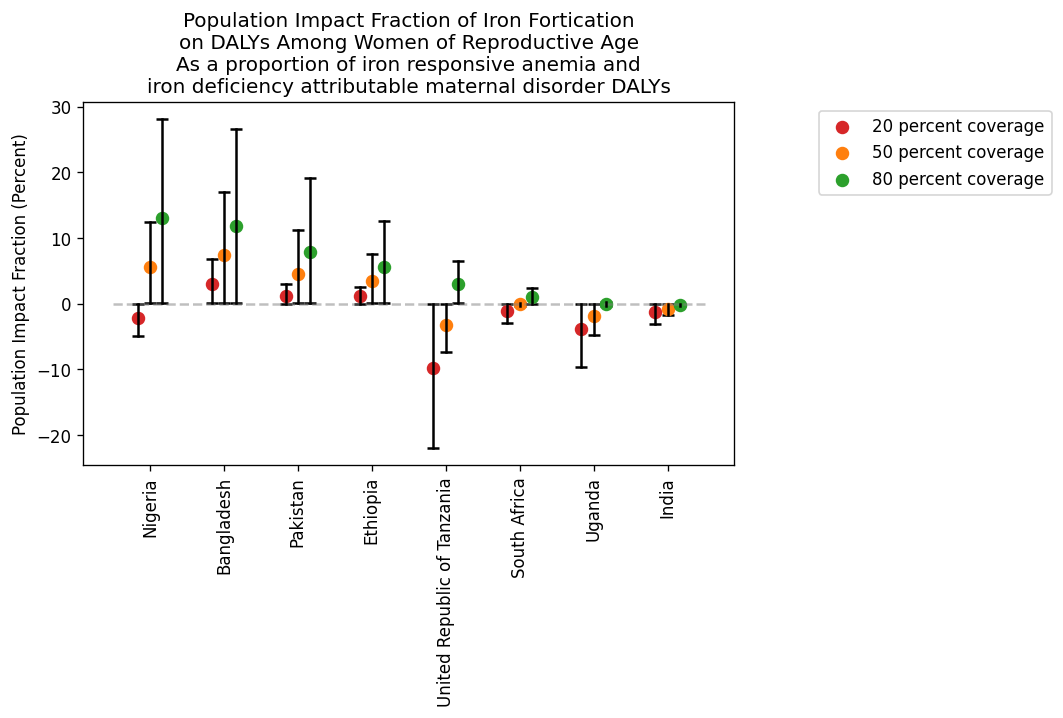

In [44]:
make_dot_plots(
    overall_pif,
    'Iron', 
    'pifs',
    coverage_levels, 
    'As a proportion of iron responsive anemia and\niron deficiency attributable maternal disorder DALYs', 
    'iron_wra_overall_pif',
    True)